# **2017 La Tuna Fire Los Angeles, California**


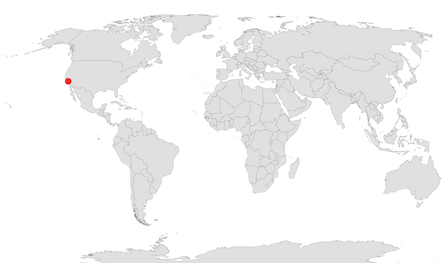

This Jupyter Notebook explores UAVSAR data over the 2017 La Tuna Fire in Los Angeles, California. The content of this notebook is as follows:

0. [Import Python Packages and Authenticate Notebook and data ](#s1)
1. [UAVSAR RGB Composite of La Tuna Fire](#s2)
2. [Create and Plot HV Transects](#s3)
3. [Time Series (dB)](#s4)


<a name="s1"></a>
## Running the Notebook
- To run the content, **select the play button** in the upper left corner of each code cell or **press shift-enter**. 
- To access the data for this notebook, download the data at this link. Click this link to a shared Google Drive data folder and "Download All." (This link is currently in my @jpl.caltech.edu Google Account and has sharing limitations. Moving forward, this would be a publically accessible folder/data download link).
  - Link to data folder: https://drive.google.com/drive/folders/1fXENic894ElRJgACE40Lx5Jfpg_oIvac?usp=sharing
  - Upload these downloaded files to Google Colab by running the cell below. A "Choose Files" button should appear. Select all the files in the downloaded folder. (Note: these will upload to a temporary "content" folder).
  - As a note, uploading larger files will take longer. If an upload error is encountered, try using Chrome instead of Safari. 

In [ ]:
from google.colab import files
uploaded = files.upload()

If the routine above is calling an error, another (faster and less data volume restricted) upload option is to expand the folder system on the left (select the folder icon) and click the upload button (icon of an upward arrow over a sheet of paper) and select all the files in the downloaded folder to upload to your "content" folder. 

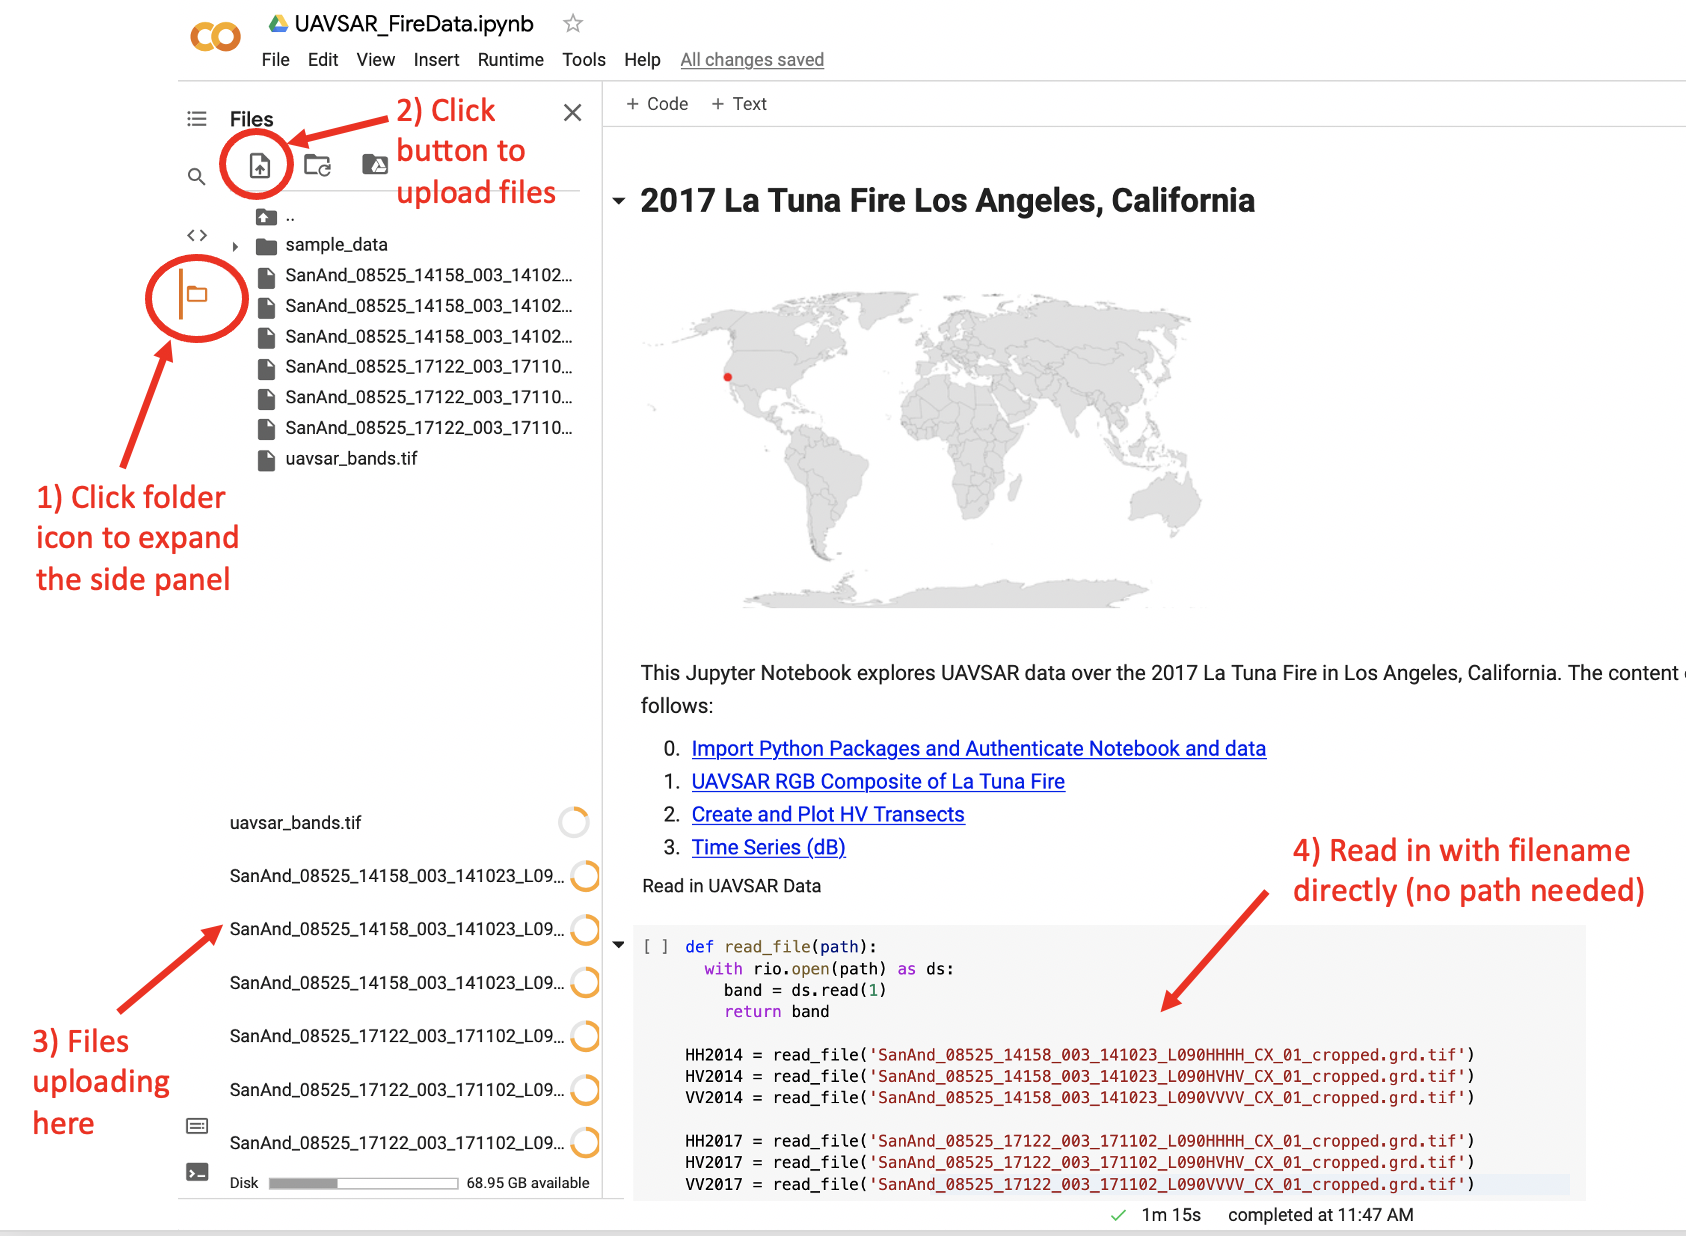

Another possibility is reading from an AWS bucket. 

For example, using the NISAR Cal/Val public bucket:


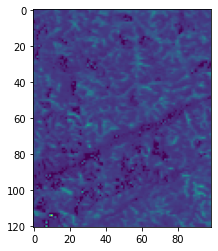

In [ ]:
bucketAddress = 'http://d3v1ox4ttgtjq7.cloudfront.net' #this address could be prettier with a JPL domain name
discipline = 'biomass'
dbAddress = 'nisar-calval-dev-west2.c0v0gfvvm2xq.us-west-2.rds.amazonaws.com'
#Get some essential information for the biomass validation product available for the TALL site
rasterName = '/vsicurl/' + bucketAddress + '/' + discipline + '/TALL/biomass/TALL_AGB_100m.tif'
ds = read_file(rasterName)
plt.imshow(ds)

Another possiblity is to fetch data from trfic using the wget command. For example: 

In [ ]:
!wget https://downloaduav2.jpl.nasa.gov/Release31/aklavi_25702_01/aklavi_25702_17070_003_170622_L090HH_01_BC_s1_1x1.slc

--2021-08-19 20:25:03--  https://downloaduav2.jpl.nasa.gov/Release31/aklavi_25702_01/aklavi_25702_17070_003_170622_L090HH_01_BC_s1_1x1.slc
Resolving downloaduav2.jpl.nasa.gov (downloaduav2.jpl.nasa.gov)... 137.78.249.121
Connecting to downloaduav2.jpl.nasa.gov (downloaduav2.jpl.nasa.gov)|137.78.249.121|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5279788800 (4.9G) [application/vnd.wap.slc]
Saving to: ‘aklavi_25702_17070_003_170622_L090HH_01_BC_s1_1x1.slc’

aklavi_25702_17070_ 100%[===================>]   4.92G  44.5MB/s    in 1m 54s  

2021-08-19 20:26:58 (44.3 MB/s) - ‘aklavi_25702_17070_003_170622_L090HH_01_BC_s1_1x1.slc’ saved [5279788800/5279788800]



### Python Packages:
This routine uses the following python libraries. Some are already included in the Google Colab environment and others are installed in the cell below before imported. 

1. rasterio
2. rasterstas
3. geopandas
4. varname
5. rioxarray
6. matplotlib 
7. numpy
8. plotly
9. skimage 
10. pathlib


In [2]:
## The packages will take around a minute to install
!pip install rasterio --quiet
!pip install rasterstats --quiet
!pip install geopandas --quiet 
!pip install rioxarray --quiet

import rasterio as rio
import rasterio.plot
from rasterio.plot import show
import rasterstats as rs
from rasterio.plot import plotting_extent

import rioxarray as rxr ## gdal Readasarray equivalent

import geopandas as gpd
import pandas as pd
from geopandas import GeoDataFrame

from shapely.geometry import Point
from shapely.geometry import Polygon

import matplotlib.pyplot as plt
from matplotlib.pyplot import xticks
import plotly.graph_objects as go

import numpy as np
from pathlib import Path
from skimage.measure import profile_line
import math

     |████████████████████████████████| 19.3 MB 31.6 MB/s 
     |████████████████████████████████| 15.4 MB 37 kB/s 
     |████████████████████████████████| 129 kB 67.2 MB/s 
     |████████████████████████████████| 994 kB 5.4 MB/s 
     |████████████████████████████████| 6.6 MB 42.8 MB/s 
     |████████████████████████████████| 46 kB 1.8 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


<a name="s2"></a>
# 1. UAVSAR RGB Composite of La Tuna Fire

The RGB UAVSAR images below show the September 2017 La Tuna Fire in the Verdugo Mountains, Los Angeles, California. The UAVSAR flightline SanAnd_08525 was acquired October 23, 2014 (Pre-fire) and November 02, 2017 (Post-fire). The fire perimeter extent is overlaid in red.

(Pre-Fire Top) 2014 Product Page: 
https://uavsar.jpl.nasa.gov/cgi-bin/product.pl?jobName=SanAnd_08525_14158_003_141023_L090_CX_01#data

(Post-Fire Bottom) 2017 Product Page: 
https://uavsar.jpl.nasa.gov/cgi-bin/product.pl?jobName=SanAnd_08525_17122_003_171102_L090_CX_01#data

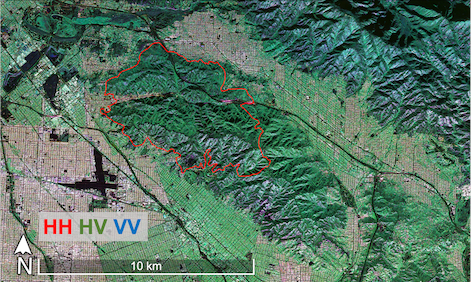

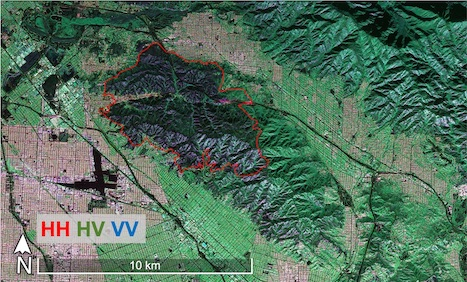

<a name="s3"></a>
## 2. Create and Plot HV Transects (Linear Power)
Below is a transect over the Verdugo mountains, spanning burned and unburned regions of the mountain range after the September 2017 La Tuna Fire. UAVSAR's HV polarization is used due to HV's sensitivity to vegetation change and transects from images pre and post fire can be uesd compare changes in HV backscatter values between areas burnt in the fire and unburnt areas. Burnt areas should have decreased HV backscatter.

Read in UAVSAR Data from AWS

In [8]:
bucketAddress = 'http://d3v1ox4ttgtjq7.cloudfront.net' #this address could be prettier with a JPL domain name
discipline = 'test/'
dbAddress = 'nisar-calval-dev-west2.c0v0gfvvm2xq.us-west-2.rds.amazonaws.com'

HH2014 = '/vsicurl/' + bucketAddress + '/' + discipline + 'SanAnd_08525_14158_003_141023_L090HHHH_CX_01_cropped.grd.tif'
HV2014 = '/vsicurl/' + bucketAddress + '/' + discipline + 'SanAnd_08525_14158_003_141023_L090HVHV_CX_01_cropped.grd.tif'
VV2014 = '/vsicurl/' + bucketAddress + '/' + discipline + 'SanAnd_08525_14158_003_141023_L090VVVV_CX_01_cropped.grd.tif'

HH2017 = '/vsicurl/' + bucketAddress + '/' + discipline + 'SanAnd_08525_17122_003_171102_L090HHHH_CX_01_cropped.grd.tif'
HV2017 = '/vsicurl/' + bucketAddress + '/' + discipline + 'SanAnd_08525_17122_003_171102_L090HVHV_CX_01_cropped.grd.tif'
VV2017 = '/vsicurl/' + bucketAddress + '/' + discipline + 'SanAnd_08525_17122_003_171102_L090VVVV_CX_01_cropped.grd.tif'

Use rasterio to open UAVSAR Data

In [9]:
def read_file(path):
  with rio.open(path) as ds:
    band = ds.read(1)
    return band

HH2014 = read_file(HH2014)
HV2014 = read_file(HV2014)
VV2014 = read_file(VV2014)

HH2017 = read_file(HH2017)
HV2017 = read_file(HV2017)
VV2017 = read_file(VV2017)

print(HH2014)

[[0.00456402 0.00456402 0.00731359 ... 0.00337009 0.00337009 0.00323988]
 [0.00771518 0.00771518 0.00538406 ... 0.00509634 0.00509634 0.0024167 ]
 [0.01003053 0.01003053 0.00976056 ... 0.00391764 0.00391764 0.00345487]
 ...
 [0.67873293 0.32198873 0.4658051  ... 0.05899433 0.04811405 0.05239956]
 [0.539634   0.32198873 0.4658051  ... 0.14835425 0.05932159 0.05932159]
 [0.16789311 0.48786396 0.48786396 ... 0.03596146 0.16470343 0.16470343]]


Convert to decibels (dB)

In [13]:
## Convert to from linear power to decibels (dB)
## Formula: 10*log10(DN)
def convert_db(data):
  db = 10*(math.log10(data))
  return db

convert_db2 = np.vectorize(convert_db)

HH2014 = convert_db2(HH2014)
HV2014 = convert_db2(HV2014)
VV2014 = convert_db2(VV2014)

HH2017 = convert_db2(HH2017)
HV2017 = convert_db2(HV2017)
VV2017 = convert_db2(VV2017)

Specify Pixel Coordinates

In [14]:
x0, y0 = 1300, 700
x1, y1 = 2200, 1300

# x0, y0 = -118.3, 34.25
# x1, y1 = -118.26, 34.19

Specify transect width with "linewidth" and transect output values with "reduce_func"

In [15]:
transect_2014 = profile_line(HV2014, (y0, x0), (y1, x1), linewidth=10, mode='nearest')#, reduce_func=np.median)
transect_2017 = profile_line(HV2017, (y0, x0), (y1, x1), linewidth=10, mode='nearest')#, reduce_func=np.median)

Plot 2014 and 2017 Data

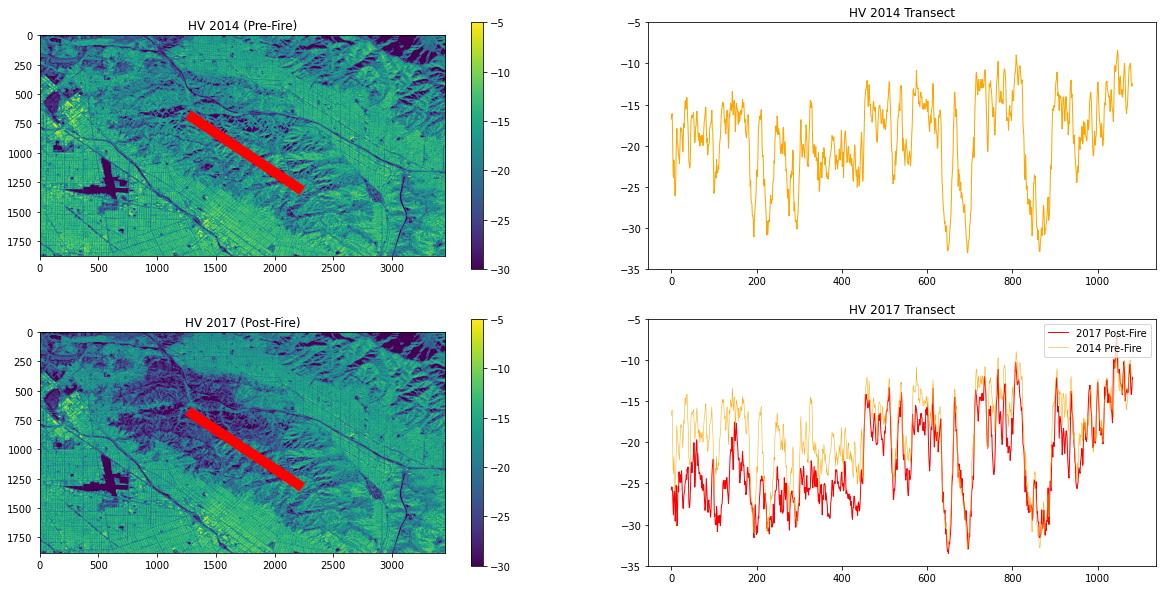

In [16]:
# with rio.open('SanAnd_08525_14158_003_141023_L090HHHH_CX_01_cropped.grd.tif') as subset_src:
#     subset_extent = plotting_extent(subset_src)

# top_left_lon = -118.3907205000000147
# top_left_lat = 34.2716026200000101
# extent_mat = (top_left_lon, top_left_lon + subset_src.shape[1] * 0.00005556000000000000337, 
#               top_left_lat - subset_src.shape[0] * 0.00005556000000000000337, top_left_lat)

############## 2014 ##############
cm = ['viridis']
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))
color = axes[0,0].imshow(HV2014, vmin=-30, vmax=-5, cmap=cm[0])#, extent=extent_mat) 
axes[0,0].plot([x0, x1], [y0, y1], 'ro-', lw=10)
axes[0,0].set_title('HV 2014 (Pre-Fire)')
fig.colorbar(color, ax=axes[0,0])

axes[0,1].plot(transect_2014, color='orange', linewidth='1')
axes[0,1].set_ylim([-35, -5])
axes[0,1].set_title('HV 2014 Transect')

############## 2017 ##############
color = axes[1,0].imshow(HV2017, vmin=-30, vmax=-5, cmap=cm[0])#, extent=extent_mat)
axes[1,0].plot([x0, x1], [y0, y1], 'ro-', lw=10)
axes[1,0].set_title('HV 2017 (Post-Fire)')
fig.colorbar(color, ax=axes[1,0])

axes[1,1].plot(transect_2017, color='red', linewidth='1')
axes[1,1].plot(transect_2014, color='orange', linewidth='0.5')
axes[1,1].set_ylim([-35, -5])
axes[1,1].set_title('HV 2017 Transect')
plt.legend(('2017 Post-Fire', '2014 Pre-Fire'),
           loc='upper right')

plt.show()

<a name="s4"></a>
## 3. Time Series (dB)
Below are subsets from UAVSAR data collection extent over the Verdugo Mountains - half over the burned area and the other half dispersed over unburnt areas. In the HV and HH polarizations, variations in values are visible between burned and unburned subsets.

The UAVSAR stack read in below was converted from linear power to decibels (dB). Formula: 10*log10(DN)

First, read in stack of UAVSAR PolSAR data from 2009 and 2020.

In [18]:
uavsar_bands = '/vsicurl/' + bucketAddress + '/' + discipline + 'uavsar_bands.tif'

uavsar_stack = rio.open(uavsar_bands)
img_stack = uavsar_bands

Then, read in shapefile of pre-selected buffered points around burnt and unburnt areas.

In [20]:
gdf_buffer = '/vsicurl/' + bucketAddress + '/' + discipline + 'gdf_buffer.shp'

In [22]:
gdf_plots = gpd.read_file(gdf_buffer)
gdf_burnt = gdf_plots[gdf_plots['fire']=='burnt']
gdf_notburnt = gdf_plots[gdf_plots['fire']=='notburnt']

Plot the buffered points on top of the UAVSAR image to see distribution of points in relation to the study area.

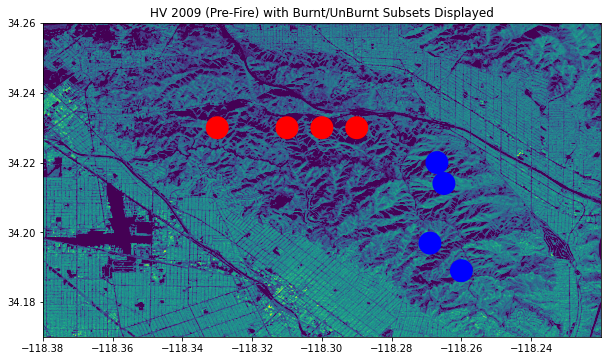

In [23]:
fig, ax = plt.subplots(figsize=(10, 10))
cm = ['viridis']

ax = gdf_burnt.plot(ax=ax, facecolor='red', edgecolor='red', linewidth=2)
ax = gdf_notburnt.plot(ax=ax, facecolor='blue', edgecolor='blue', linewidth=2)
ax.set_title('HV 2009 (Pre-Fire) with Burnt/UnBurnt Subsets Displayed')

show((uavsar_stack, 1), ax=ax, vmin=-25, vmax=0, cmap=cm[0])

Extract mean and other statistics from areas of shapefile and raster overlap.

In [26]:
def zstats(vector, band, postfix):
    result = rs.zonal_stats(vector, uavsar_bands, band=band, stats='mean min max', geojson_out=True)
    for f in result:
        props = f['properties']
        props[postfix] = props.pop('mean')
        props = props[postfix]
        props2 = f['properties']
        props2[postfix] = props2.pop('max')
        props2 = props2[postfix]
        props3 = f['properties']
        props3[postfix] = props3.pop('min')
        props3 = props3[postfix]
        all = [props, props2, props3]
    return all

burnt_process = [
    (gdf_burnt, 1, '2009'),
    (gdf_burnt, 2, '2010'),
    (gdf_burnt, 3, '2011'),
    (gdf_burnt, 4, '2012'),
    (gdf_burnt, 5, '2014'),
    (gdf_burnt, 6, '2017'),
    (gdf_burnt, 7, '2018'),
    (gdf_burnt, 8, '2020')
]

notburnt_process = [
    (gdf_notburnt, 1, '2009'),
    (gdf_notburnt, 2, '2010'),
    (gdf_notburnt, 3, '2011'),
    (gdf_notburnt, 4, '2012'),
    (gdf_notburnt, 5, '2014'),
    (gdf_notburnt, 6, '2017'),
    (gdf_notburnt, 7, '2018'),
    (gdf_notburnt, 8, '2020')
]

burnt_stats = [zstats(*args) for args in burnt_process]
notburnt_stats = [zstats(*args) for args in notburnt_process]
years = ['2009','2010','2011','2012','2014','2017','2018','2020']

burnt_stats_df = pd.DataFrame(burnt_stats,columns=['burnt mean', 'burnt max','burnt min'])
notburnt_stats_df = pd.DataFrame(notburnt_stats, columns=['not burnt mean', 'not burnt max','not burnt min'])

/usr/local/lib/python3.7/dist-packages/rasterstats/io.py:302: UserWarning:

Setting nodata to -999; specify nodata explicitly



Print out data frame of Burnt vs. Non-Burnt mean, min, and max

In [27]:
years = pd.Series(years, name="Year")
pd.to_datetime(years)
burnt_stats_df = pd.merge(years, burnt_stats_df, right_index=True, left_index=True)
burnt_stats_df = pd.merge(burnt_stats_df, notburnt_stats_df, right_index=True, left_index=True)

burnt_stats_df

,Year,burnt mean,burnt max,burnt min,not burnt mean,not burnt max,not burnt min
0,2009,-23.355330,-5.932755,-41.715858,-18.902123,-6.153824,-35.490726
1,2010,-23.172589,-6.953382,-41.617771,-18.258309,-5.647788,-35.282635
2,2011,-22.266615,-7.859430,-36.966049,-18.298684,-5.038753,-33.973343
3,2012,-22.353706,-6.629800,-36.821026,-18.395449,-4.563482,-34.874081
4,2014,-22.042698,-4.263805,-37.411942,-18.142646,-5.040717,-34.185871
5,2017,-27.028996,-9.001712,-37.978092,-18.375389,-6.055192,-33.777374
6,2018,-25.509915,-7.198468,-35.078541,-17.653546,-5.203991,-33.696453
7,2020,-25.932999,-7.830916,-36.895172,-17.088209,-5.383451,-31.470165


In [28]:
#@title Time Series Plot
######## Plot Time series ########
## Change so the spread is based on the min/max from the standard deviation

fig = go.Figure()
# fig.add_trace(go.Scatter(x=burnt_stats_df["Year"], y=burnt_stats_df["burnt mean"], name="Not Burnt", 
#                          error_y="burnt max", error_y_minus="burnt min"
#     ))

fig.add_trace(go.Scatter(x=burnt_stats_df["Year"], y=burnt_stats_df["burnt mean"], name="Burnt", error_y=dict(
            type='percent', # value of error bar given in data coordinates
            symmetric=False,
            value=25,
            valueminus=25)
    ))

fig.add_trace(go.Scatter(x=burnt_stats_df["Year"], y=burnt_stats_df["not burnt mean"], name="Not Burnt", error_y=dict(
            type='percent', # value of error bar given in data coordinates
            symmetric=False,
            value=25,
            valueminus=25)
    ))

fig.update_xaxes(
    dtick="M1",
    tickformat="\n%Y")

fig.update_layout(
    title="Burnt vs Unburnt HV Subsets over Fire Scar",
    xaxis_title="Year of UAVSAR Collection",
    yaxis_title="dB Power",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="Black"
    )
)

fig.show()

#With matplotlib:
#plt.fill_between(range(100), mean-standard_dev, mean+standard_dev, alpha = 0.5)

This time series plots the mean of the burnt and unburnt subsets from UAVSAR collections 2009 - 2020. At each acquisition point, the error bars extend plus and minus 25% of the data's spread.